In [1]:
from sklearn.metrics.pairwise import cosine_similarity

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
doc = "You say goodbye and I say hello. Say you love me and i will."

In [3]:
word2idx = dict()
idx2word = dict()

word_list = doc.replace(".", "").lower().split()
word_list

['you',
 'say',
 'goodbye',
 'and',
 'i',
 'say',
 'hello',
 'say',
 'you',
 'love',
 'me',
 'and',
 'i',
 'will']

In [4]:
for word in word_list:
  if word not in word2idx:
    index = len(word2idx)

    word2idx[word] = index
    idx2word[index] = word

word2idx, idx2word

({'and': 3,
  'goodbye': 2,
  'hello': 5,
  'i': 4,
  'love': 6,
  'me': 7,
  'say': 1,
  'will': 8,
  'you': 0},
 {0: 'you',
  1: 'say',
  2: 'goodbye',
  3: 'and',
  4: 'i',
  5: 'hello',
  6: 'love',
  7: 'me',
  8: 'will'})

In [5]:
doc_idx = [word2idx[word] for word in word_list]
doc_idx

[0, 1, 2, 3, 4, 1, 5, 1, 0, 6, 7, 3, 4, 8]

In [6]:
doc_size = len(doc_idx)
lexicon_size = len(set(doc_idx))
zero_matrix = np.zeros((lexicon_size, lexicon_size), dtype=np.int32)
zero_matrix

array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)

In [7]:
window_size = 1
for focus_idx, focus_word_idx in enumerate(doc_idx):
  for i in range(1, window_size+1):
    left = focus_idx - window_size
    right = focus_idx + window_size

    if left >= 0:
      left_idx = doc_idx[left]
      zero_matrix[focus_word_idx, left_idx] += 1
    if right < doc_size:
      right_idx = doc_idx[right]
      zero_matrix[focus_word_idx, right_idx] += 1

zero_matrix

array([[0, 2, 0, 0, 0, 0, 1, 0, 0],
       [2, 0, 1, 0, 1, 2, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 2, 0, 0, 1, 0],
       [0, 1, 0, 2, 0, 0, 0, 0, 1],
       [0, 2, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0]], dtype=int32)

In [8]:
df = pd.DataFrame(zero_matrix,
                  columns=idx2word.values(),
                  index=idx2word.values())
df

,you,say,goodbye,and,i,hello,love,me,will
you,0,2,0,0,0,0,1,0,0
say,2,0,1,0,1,2,0,0,0
goodbye,0,1,0,1,0,0,0,0,0
and,0,0,1,0,2,0,0,1,0
i,0,1,0,2,0,0,0,0,1
hello,0,2,0,0,0,0,0,0,0
love,1,0,0,0,0,0,0,1,0
me,0,0,0,1,0,0,1,0,0
will,0,0,0,0,1,0,0,0,0


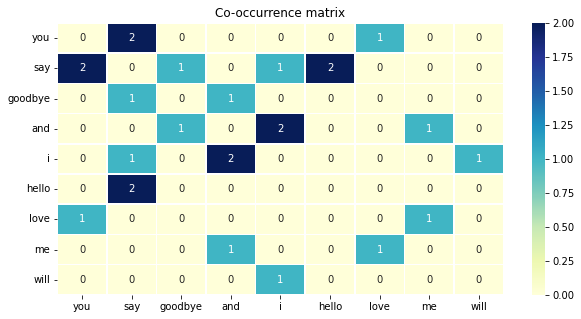

In [9]:
plt.figure(figsize=(10, 5))
sns.heatmap(df,
            annot=True,
            xticklabels=idx2word.values(),
            yticklabels=idx2word.values(),
            linewidth=.5,   # 조금 띄워준다
            cmap="YlGnBu")   # 색깔
plt.title("Co-occurrence matrix")
plt.show()

In [10]:
def get_indexes(doc):
  word_list = doc.replace(".", "").lower().split()
  word2idx, idx2word = {}, {}
  for word in word_list:
    if word not in word2idx:
      index = len(word2idx)

      word2idx[word] = index
      idx2word[index] = word

  doc_idx = [word2idx[w] for w in word_list]
  return doc_idx, word2idx, idx2word

def get_comatrix(doc_idx, window_size=1):
  corpus_size = len(doc_idx)
  vocab_size = len(set(doc_idx))
  matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)
  
  for idx, word_id in enumerate(doc_idx):
    for i in range(1, window_size+1):
      left_idx, right_idx = idx-window_size, idx+window_size

      if left_idx >= 0:
        left_word_id = doc_idx[left_idx]
        matrix[word_id, left_word_id] += 1

      if right_idx < corpus_size:
        right_word_id = doc_idx[right_idx]
        matrix[word_id, right_word_id] += 1
  return matrix
  
doc_idx, _, _ = get_indexes(doc)
test = get_comatrix(doc_idx)

In [20]:
def ppmi(C, eps=1e-8):
  M = np.zeros_like(C, dtype=np.float32)
  N = np.sum(C)
  S = np.sum(C, axis=0)   # row 발생 횟수

  for i in range(C.shape[0]):
    for j in range(C.shape[1]):
      pmi = np.log2(C[i, j] * N / (S[i] * S[j] + eps))
      M[i, j] = max(pmi, 0)
  return M

In [12]:
np.set_printoptions(precision=3)

In [21]:
ppmi(C=test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log2
  


array([[0.   , 1.531, 0.   , 0.   , 0.   , 0.   , 2.115, 0.   , 0.   ],
       [1.531, 0.   , 1.115, 0.   , 0.115, 2.115, 0.   , 0.   , 0.   ],
       [0.   , 1.115, 0.   , 1.7  , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 1.7  , 0.   , 1.7  , 0.   , 0.   , 1.7  , 0.   ],
       [0.   , 0.115, 0.   , 1.7  , 0.   , 0.   , 0.   , 0.   , 2.7  ],
       [0.   , 2.115, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [2.115, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 2.7  , 0.   ],
       [0.   , 0.   , 0.   , 1.7  , 0.   , 0.   , 2.7  , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 2.7  , 0.   , 0.   , 0.   , 0.   ]],
      dtype=float32)

In [14]:
get_indexes("I am a boy")

([0, 1, 2, 3],
 {'a': 2, 'am': 1, 'boy': 3, 'i': 0},
 {0: 'i', 1: 'am', 2: 'a', 3: 'boy'})

In [22]:
def most_similar(query, doc, top=5):   # ppmi 이용
  # co matrix
  doc_idx, word2id, id2word = get_indexes(doc)
  if query not in word2id : raise Exception()   # check for availability
  
  co_matrix = get_comatrix(doc_idx)
  ppmi_matrix = ppmi(co_matrix)

  query_id = word2id[query]
  query_matrix = ppmi_matrix[query_id].reshape(1, -1)

  cosine = cosine_similarity(query_matrix, ppmi_matrix).squeeze().tolist()   # query-ppmi
  dic = dict()
  for i in range(len(id2word)):
    word = id2word[i]
    score = cosine[i]
    dic[word] = cosine[i]
  dic = sorted(dic.items(), key=(lambda x: x[1]), reverse=True)
  similar_word_list = [i for i, _ in dic[1:]][:top]
  return similar_word_list

most_similar("you", doc)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log2
  


['me', 'hello', 'goodbye', 'i', 'say']

# Movie Review with PPMI

In [16]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [17]:
import pandas as pd
import numpy as np

PATH = "/gdrive/MyDrive/01. Programming/Practical NLP/data/Week 12/"

df = pd.read_csv(PATH + "movies_metadata.csv", low_memory=False)
df = df[['overview', 'title']]

print(df.isnull().sum())   # check for NaN values
df = df.fillna(" ")
print(df.isnull().sum())   # check for NaN values

df = df[:100].reset_index(drop=True)
df

overview    954
title         6
dtype: int64
overview    0
title       0
dtype: int64


,overview,title
0,"Led by Woody, Andy's toys live happily in his ...",Toy Story
1,When siblings Judy and Peter discover an encha...,Jumanji
2,A family wedding reignites the ancient feud be...,Grumpier Old Men
3,"Cheated on, mistreated and stepped on, the wom...",Waiting to Exhale
4,Just when George Banks has recovered from his ...,Father of the Bride Part II
...,...,...
95,Aimlessly whiling away their days in the concr...,La Haine
96,"A dark, hip, urban story of a barren and anony...",Shopping
97,A documentary crew from the BBC arrives in L.A...,Heidi Fleiss: Hollywood Madam
98,The accidental shooting of a boy in New York l...,City Hall


In [ ]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence as tokenizer

import nltk

def create_corpus(df):
  data = " ".join(df['overview'].tolist())
  data = tokenizer(data)
  fdist = nltk.FreqDist(data)
  return fdist

create_corpus(df)

In [24]:
def recommendMovie_cv(movie):
  
  if movie not in df['title'].tolist(): raise Exception('The movie you searched for does not exist.')
  data = df['overview'].tolist()
  doc = " ".join(data)
  return doc
  doc_idx, word2id, id2word = get_indexes(doc)
  co_matrix = get_comatrix(doc_idx)
  ppmi_matrix = ppmi(co_matrix)
  
  # 1. query
  info = OrderedDict()   # key: similarity, value: movie name
  query_index = df.index[df['title'] == movie][0]   # 같은 영화, 다른 overview일 경우, 앞에 나온 overview 사용
  query_matrix = ppmi_matrix[query_index].reshape(1, -1)
  return query_matrix
  scores = cosine_similarity(query_vector, count_dtm).T

  scores[query_index] = 1e-7   # 자기 자신과의 similarity를 작은 값으로 초기화

  for i in range(len(scores)):
    info[scores[i].item()] = df.loc[i, "title"]   # OrderedDict에 정보 추가
  sorted_info = OrderedDict(sorted(info.items(), key=lambda x: x[0], reverse=True))

  # 2. answer: top 5 similar movies
  for rank, (_, name) in enumerate(sorted_info.items(), 1):
    print(f"#{rank}. {name}")
    if rank == 5 : break

recommendMovie_cv("Toy Story")

'Led by Woody, Andy\'s toys live happily in his room until Andy\'s birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy\'s heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences. When siblings Judy and Peter discover an enchanted board game that opens the door to a magical world, they unwittingly invite Alan -- an adult who\'s been trapped inside the game for 26 years -- into their living room. Alan\'s only hope for freedom is to finish the game, which proves risky as all three find themselves running from giant rhinoceroses, evil monkeys and other terrifying creatures. A family wedding reignites the ancient feud between next-door neighbors and fishing buddies John and Max. Meanwhile, a sultry Italian divorcée opens a restaurant at the local bait shop, alarming the locals who worry she\'ll scare the fish away. But she\'s less interested in seafood than she is

In [ ]:
def movie_recommend(query, model=TfidfVectorizer->PPMI):
  # toy story